In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1.0 Loading the dataset

In [2]:
df = pd.read_csv('kiva.csv')

In [3]:
df.head()

,country,en,gender,loan_amount,nonpayment,sector,status
0,Dominican Republic,"""Banco Esperanza"" is a group of 10 women looki...",F,1225.0,partner,Retail,paid
1,Dominican Republic,"""Caminemos Hacia Adelante"" or ""Walking Forward...",F,1975.0,lender,Clothing,paid
2,Dominican Republic,"""Creciendo Por La Union"" is a group of 10 peop...",F,2175.0,partner,Clothing,paid
3,Dominican Republic,"""Cristo Vive"" (""Christ lives"" is a group of 10...",F,1425.0,partner,Clothing,paid
4,Dominican Republic,"""Cristo Vive"" is a large group of 35 people, 2...",F,4025.0,partner,Food,paid


## 2.0 Defining the Stopwords

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['loan', 'income', 'usd', 'many', 'also', 'make', 'business', 'buy', 'sell', 'purchase',
                  'year', 'people', 'able', 'enable', 'old'])

## 3.0 Pre-processing text data

### 3.1 Regex Expressions

In [5]:
# Convert to list
data = df.en.values.tolist()

#REGEX
clean_data = []
for i in range(0,len(data)):
    review = re.sub(r'\W', ' ', str(data[i]))
    review = review.lower()
    review = re.sub(r'\s+[a-z]\s+', ' ', review)
    review = re.sub(r'^[a-z]\s+', ' ', review)
    review = re.sub(r'\d+', ' ', review)
    review = re.sub(r'\s+', ' ', review)
    clean_data.append(review)

data = clean_data #re-assigning clean_data to >>> data <<<

### 3.2 Word Tokenizer

In [6]:
#Word Tokenization using gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

### 3.3 N-gram Extraction 

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## 3.3 Remove Stop Words, Make Bi-Grams and Lemmatize

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## 4.0 Modeling 

### 4.1 Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### 4.2 Build LDA Model 

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[corpus]

[(0,
  '0.051*"group" + 0.031*"member" + 0.026*"milk" + 0.022*"woman" + '
  '0.021*"farm" + 0.021*"child" + 0.020*"repay" + 0.019*"month" + '
  '0.018*"maize" + 0.015*"marry"'),
 (1,
  '0.015*"work" + 0.012*"start" + 0.011*"first" + 0.011*"make" + 0.011*"home" '
  '+ 0.010*"training" + 0.010*"use" + 0.010*"wife" + 0.010*"area" + '
  '0.010*"child"'),
 (2,
  '0.109*"farmer" + 0.053*"land" + 0.035*"farm" + 0.030*"crop" + 0.017*"seed" '
  '+ 0.015*"fertilizer" + 0.014*"pig" + 0.012*"rice" + 0.011*"area" + '
  '0.011*"livestock"'),
 (3,
  '0.031*"child" + 0.027*"school" + 0.021*"year" + 0.018*"sell" + '
  '0.017*"family" + 0.013*"stock" + 0.012*"increase" + 0.011*"marry" + '
  '0.011*"start" + 0.010*"request"')]


### 4.3 Calculate Perplexity and Coherence 

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.048794897267131

Coherence Score:  0.5187299469928104


## 4.4 Visualizing Topic Models

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.179948 -0.158959       1        1  50.895275
1     -0.197872  0.102195       2        1  28.464407
0      0.234576 -0.180812       3        1  10.798634
2      0.143244  0.237575       4        1   9.841683, topic_info=     Category         Freq             Term        Total  loglift  logprob
1644  Default  4610.000000           farmer  4610.000000  30.0000  30.0000
763   Default  2232.000000             land  2232.000000  29.0000  29.0000
12    Default  2462.000000            group  2462.000000  28.0000  28.0000
610   Default  2489.000000             farm  2489.000000  27.0000  27.0000
221   Default  6403.000000           school  6403.000000  26.0000  26.0000
72    Default  1623.000000           member  1623.000000  25.0000  25.0000
5152  Default  1265.000000             crop  1265.000000  24.0000  24.0000
43    Default  1753.000000            woman  1753.000000  23.0000  23.0000
573   Default  1283.000000             milk  1283.000000  22.0000  22.0000
112   Default  3118.000000            marry  3118.000000  21.0000  21.0000
5     Default  8889.000000            child  8889.000000  20.0000  20.0000
75    Default  2065.000000            repay  2065.000000  19.0000  19.0000
218   Default  1751.000000            month  1751.000000  18.0000  18.0000
470   Default  2938.000000            stock  2938.000000  17.0000  17.0000
6430  Default   819.000000            maize   819.000000  16.0000  16.0000
122   Default  4943.000000             year  4943.000000  15.0000  15.0000
4025  Default   709.000000             seed   709.000000  14.0000  14.0000
538   Default  1429.000000             home  1429.000000  13.0000  13.0000
5216  Default   650.000000       fertilizer   650.000000  12.0000  12.0000
98    Default  1929.000000             area  1929.000000  11.0000  11.0000
325   Default  2169.000000          request  2169.000000  10.0000  10.0000
1117  Default  1026.000000          primary  1026.000000   9.0000   9.0000
441   Default  1719.000000              fee  1719.000000   8.0000   8.0000
632   Default  1291.000000             wife  1291.000000   7.0000   7.0000
293   Default  1414.000000         training  1414.000000   6.0000   6.0000
68    Default  2663.000000         increase  2663.000000   5.0000   5.0000
1102  Default   577.000000              pig   577.000000   4.0000   4.0000
253   Default  2013.000000           market  2013.000000   3.0000   3.0000
90    Default   905.000000             loan   905.000000   2.0000   2.0000
251   Default   689.000000            apply   689.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
3799   Topic4    57.490234      insecticide    58.231697   2.3057  -6.6041
5726   Topic4    57.261425         affected    58.025421   2.3053  -6.6081
5233   Topic4    54.824677    commercialize    55.565334   2.3051  -6.6516
3528   Topic4    56.975784           freely    57.768410   2.3047  -6.6131
5619   Topic4    51.251644      cultivation    51.997379   2.3041  -6.7190
5796   Topic4    76.549789  almost_everyone    77.671326   2.3040  -6.3178
2200   Topic4    49.338142     intermediary    50.079712   2.3036  -6.7570
5227   Topic4    48.879395        machinery    49.624294   2.3034  -6.7664
5153   Topic4   206.426971            input   211.847275   2.2926  -5.3258
946    Topic4   350.215759           sector   381.010376   2.2343  -4.7972
3380   Topic4   424.732849            plant   508.079498   2.1394  -4.6043
550    Topic4   501.727264             rice   616.456726   2.1126  -4.4377
1951   Topic4   102.437912          economy   113.011192   2.2203  -6.0265
5832   Topic4    82.841545           manure    88.628563   2.2510  -6.2388
610    Topic4  1504.117554             farm  2489.282715   1.8148  -3.3398
5218   Topic4   293.254669          harvest   388.903137   2.0363  -4.9747
270    Topic4   238.008820       

### 4.5 Finding the optimal number of K

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word,num_topics=num_topics, 
                                                random_state=100, update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

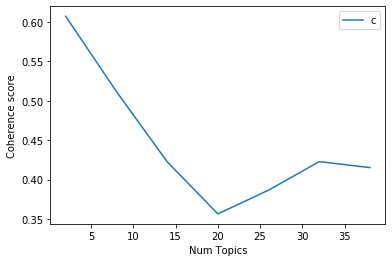

In [16]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## 5.0 Attaching the Results back to original dataframe 

In [17]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #row = sorted(row, key=lambda x: (x[1]), reverse=True)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

#Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5123,"work, start, first, make, home, training, use,...",banco esperanza is group of women looking to ...
1,1,3.0,0.5130,"child, school, year, sell, family, stock, incr...",caminemos hacia adelante or walking forward i...
2,2,1.0,0.5318,"work, start, first, make, home, training, use,...",creciendo por la union is group of people hop...
3,3,1.0,0.4999,"work, start, first, make, home, training, use,...",cristo vive christ lives is group of women wh...
4,4,1.0,0.5660,"work, start, first, make, home, training, use,...",cristo vive is large group of people of which...
5,5,1.0,0.5493,"work, start, first, make, home, training, use,...",dios con nosotros is large group of esperanza...
6,6,1.0,0.6922,"work, start, first, make, home, training, use,...",dios nuestro ayudador is group of haitian wom...
7,7,1.0,0.5793,"work, start, first, make, home, training, use,...",el amor is large group of borrowers in this l...
8,8,1.0,0.6264,"work, start, first, make, home, training, use,...",emmanuel is group of people women and men the...
9,9,1.0,0.6644,"work, start, first, make, home, training, use,...",esfuerzate sed valiente is group of women com...


##  5.1 Finding the most representative document for each topic 

In [18]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8193,"group, member, milk, woman, farm, child, repay...",frida kabura kuria is years old she is married...
1,1.0,0.8639,"work, start, first, make, home, training, use,...",b business description p carlos has store whe...
2,2.0,0.9676,"farmer, land, farm, crop, seed, fertilizer, pi...",angela and her husband live on farm in baba e...
3,3.0,0.9775,"child, school, year, sell, family, stock, incr...",rosemary awour okonya is year old widow with t...


##  5.2 Topic distribution across documents

In [19]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"group, member, milk, woman, farm, child, repay...",536,0.0778
1,1.0,"work, start, first, make, home, training, use,...",1698,0.2464
2,2.0,"farmer, land, farm, crop, seed, fertilizer, pi...",163,0.0237
3,3.0,"child, school, year, sell, family, stock, incr...",4495,0.6522


## 6.0 Preparing the final dataset for classification

In [20]:
df.head()

,country,en,gender,loan_amount,nonpayment,sector,status
0,Dominican Republic,"""Banco Esperanza"" is a group of 10 women looki...",F,1225.0,partner,Retail,paid
1,Dominican Republic,"""Caminemos Hacia Adelante"" or ""Walking Forward...",F,1975.0,lender,Clothing,paid
2,Dominican Republic,"""Creciendo Por La Union"" is a group of 10 peop...",F,2175.0,partner,Clothing,paid
3,Dominican Republic,"""Cristo Vive"" (""Christ lives"" is a group of 10...",F,1425.0,partner,Clothing,paid
4,Dominican Republic,"""Cristo Vive"" is a large group of 35 people, 2...",F,4025.0,partner,Food,paid


In [21]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5123,"work, start, first, make, home, training, use,...",banco esperanza is group of women looking to ...
1,1,3.0,0.5130,"child, school, year, sell, family, stock, incr...",caminemos hacia adelante or walking forward i...
2,2,1.0,0.5318,"work, start, first, make, home, training, use,...",creciendo por la union is group of people hop...
3,3,1.0,0.4999,"work, start, first, make, home, training, use,...",cristo vive christ lives is group of women wh...
4,4,1.0,0.5660,"work, start, first, make, home, training, use,...",cristo vive is large group of people of which...


In [22]:
df['topic'] = df_dominant_topic['Dominant_Topic']
df['perc'] = df_dominant_topic['Topic_Perc_Contrib']

In [23]:
#check final df to see if topic and perc is attached
df.head()

,country,en,gender,loan_amount,nonpayment,sector,status,topic,perc
0,Dominican Republic,"""Banco Esperanza"" is a group of 10 women looki...",F,1225.0,partner,Retail,paid,1.0,0.5123
1,Dominican Republic,"""Caminemos Hacia Adelante"" or ""Walking Forward...",F,1975.0,lender,Clothing,paid,3.0,0.5130
2,Dominican Republic,"""Creciendo Por La Union"" is a group of 10 peop...",F,2175.0,partner,Clothing,paid,1.0,0.5318
3,Dominican Republic,"""Cristo Vive"" (""Christ lives"" is a group of 10...",F,1425.0,partner,Clothing,paid,1.0,0.4999
4,Dominican Republic,"""Cristo Vive"" is a large group of 35 people, 2...",F,4025.0,partner,Food,paid,1.0,0.5660


In [25]:
df.to_csv('C:/Users/mali085/kiva_topic_assigned.csv')